this is a classification problem and we got original data which contains 5 features and 3 labels, each pixel can regarded as a sample

# 1.Frame the problem

# 2.Input the data

In [48]:
#all packages which will be used
import numpy as np
import pandas as pd
from scipy.io import loadmat
import time
import random

#plot
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
#from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

#scipy
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.spatial import distance


#math
from math import log

In [140]:
#data=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\dataset.mat")
dataset=loadmat("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\dataset.mat",mat_dtype=True)

In [141]:
data=dataset["dataset"]
type(data)

numpy.ndarray

then we try to plot one image to see what it looks like

In [142]:
data[12][0][0][0][3].shape
#for element in data[12][0][0][0][1][:,:,20].flat:
    #assert element == 0

(320, 320, 43)

In [143]:
for i in range(len(data)):
    print(data[i][0][0][0][0][:,:,3,1].shape)
    
len(data)

(34, 41)
(80, 82)
(82, 74)
(89, 102)
(66, 78)
(69, 83)
(50, 57)
(55, 69)
(64, 65)
(99, 83)
(107, 99)
(320, 320)
(320, 320)
(320, 320)


14

In [144]:
data2=data[1][0][0][0][0][:,:,8,0] #[:,:,slices,features]

In [145]:
def plot_image(data,stuck,slices,features):
    target_data=data[stuck][0][0][0][0][:,:,slices,features]
    target_image=target_data.reshape(target_data.shape[0],target_data.shape[1])
    plt.imshow(target_image,cmap = matplotlib.cm.binary)
    plt.axis("off") #close the axis number
    plt.show()


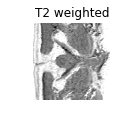

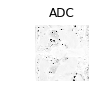

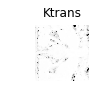

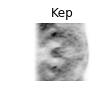

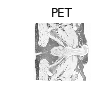

In [146]:
stuck,slices,features=11,10,0
plt.figure(figsize=(8,4))

plt.subplot(151)
plt.title("T2 weighted")
plot_image(data,stuck,slices,features)

plt.subplot(152)
plt.title("ADC")
plot_image(data,stuck,slices,features+1)

plt.subplot(153)
plt.title("Ktrans")
plot_image(data,stuck,slices,features+2)

plt.subplot(154)
plt.title("Kep")
plot_image(data,stuck,slices,features+3)

plt.subplot(155)
plt.title("PET")
plot_image(data,stuck,slices,features+4)

then we try to find out the labels distribution

In [147]:
labelA=data[3][0][0][0][1]
labelA.shape

(89, 102, 85)

In [148]:
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap',['black','red','blue'],256)
def plot_all(data,stuck,index,slices,features):
    target_data=data[stuck][0][0][0][0][:,:,slices,features]
    target_image1=target_data.reshape(target_data.shape[0],target_data.shape[1])
    target_label=data[stuck][0][0][0][index][:,:,slices]
    target_image2=target_label.reshape(target_label.shape[0],target_label.shape[1])
    plt.imshow(target_image1,cmap = matplotlib.cm.binary,alpha=0.8)
    plt.imshow(target_image2,cmap = cmap1,interpolation="bilinear",alpha=0.2)
    plt.axis("off") #close the axis number
    plt.show()



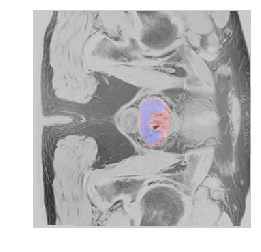

In [149]:
stuck,slices,index,features=13,20,1,4
#plot_image(data,stuck,slices,0)
#plot_label(data,stuck,2,slices)
plot_all(data,stuck,index,slices,features)

# 3. Exploring the features

## 3.1 Extract prostate region

we can find that 1-11 strucks are expected by experts and 12-14 are histological analysis because it is more reliable than the experts,and later 1-11 strucks will be out training set and 12-14 will be out validation set

In [150]:

experts_num,histo_num=11,3
label_final=[]
for i in range(experts_num):
    labelA=data[i][0][0][0][1]
    labelB=data[i][0][0][0][2]
    for index,(item_A,item_B) in enumerate(zip(labelA.flat,labelB.flat)):
                if item_A == item_B:
                    pass
                else:
                    labelA.flat[index]=0
    label_final.append(labelA)


then append the histological struck

In [151]:
for j in range(histo_num):
    labelC=data[j+11][0][0][0][3]
    label_final.append(labelC)

label=np.array(label_final)
label.shape

(14,)

then our task divided into two parts:
- isolate the feature vector of prostate tissure from the whole set
- try to transfer first feature TR wighted MR images

then let us create train data set and validation set respectively

In [152]:
train_data=data[:experts_num]
train_label=label[:experts_num]
val_data=data[:-experts_num]
val_label=label[:-experts_num]
val_label.shape

(3,)

In [154]:
train_isolated_feature=[]
train_isolated_label=[]
val_isolated_feature=[]
val_isolated_label=[]
def isolate_feature(data,label,isolated_feature,isolated_label):
    for i in range(len(data)):
        image=data[i][0][0][0][0]
        target_image=image.reshape(image.shape[0]*image.shape[1]*image.shape[2],image.shape[3])
        target_label=label[i].reshape(-1,1)
        for index,item in enumerate(target_label):
            if item == 0 :
                pass
            else:
                isolated_label.append(item)
                isolated_feature.append(target_image[index])
    return isolated_feature,isolated_label
        

isolate_feature(train_data,train_label,train_isolated_feature,train_isolated_label)
isolate_feature(val_data,val_label,val_isolated_feature,val_isolated_label)

print(len(train_isolated_feature))

355455


In [155]:
train_isolated_feature=pd.DataFrame(np.array(train_isolated_feature))
train_isolated_label=pd.DataFrame(np.array(train_isolated_label))
val_isolated_feature=pd.DataFrame(np.array(val_isolated_feature))
val_isolated_label=pd.DataFrame(np.array(val_isolated_label))
train_isolated_feature.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_feature.csv",index=False)
train_isolated_label.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_label.csv",index=False)
val_isolated_feature.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\val_feature.csv",index=False)
val_isolated_label.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\val_label.csv",index=False)
len(train_isolated_feature)

355455

it means that prostate area has 355455 voxels

In [156]:
sum_d=0
for i in range(11):
    temp_data=data[i][0][0][0][0]
    temp_d=temp_data.reshape(temp_data.shape[0]*temp_data.shape[1]*temp_data.shape[2],temp_data.shape[3])
    sum_d +=temp_d.shape[0]
    
sum_d

4696937

total voxel is 4696937

## 3.2 Normalization & Outliers detection

so we see we isolated the 355455 prostate features from the 4696937 the whole train set

then try to construct the whole pipeline of the features enginerring
- Transform the first feature TR wighted
- normalize all the features
- Outlier detection and removal

In [15]:
#read data
X_train=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_feature.csv")
y_train=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_label.csv")
X_val=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\val_feature.csv")
y_val=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\val_label.csv")

In [16]:
scaler1=MinMaxScaler(feature_range=(0, 1), copy=True)
class Feature_scaling(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        scaler1.fit(X['0'])
        return self
    def transform(self,X,y=None):
        X['0']=scaler1.transform(X['0'])
        return X

In [17]:
scaler2=StandardScaler()
class Normalization(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        scaler2.fit(X[["1","2","3","4"]])
        return self
    def transform(self,X,y=None):
        X[["1","2","3","4"]]=scaler2.transform(X[["1","2","3","4"]])
        return pd.DataFrame(X)

In [18]:
feature_eng=Pipeline([("feature_scale",Feature_scaling()),
                     ("normalization",Normalization())])

In [19]:
feature_eng.fit_transform(X_train)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


,0,1,2,3,4
0,0.799095,0.912633,-0.144782,-1.213436,2.065894
1,0.790365,1.013452,-0.137170,-1.207106,2.118748
2,0.767685,0.602602,-0.177170,-1.120504,2.233095
3,0.752462,0.271475,-0.225923,-1.127930,2.153350
4,0.902552,1.153892,-0.190460,-1.184571,1.867942
5,0.889425,1.321699,-0.177952,-1.202120,0.839332
6,0.879032,1.427166,-0.167475,-1.234619,1.693697
7,0.867083,1.411221,-0.150459,-1.249641,2.451205
8,0.830395,1.338901,-0.174656,-1.248578,1.102973
9,0.843642,1.306003,-0.127406,-1.293149,1.065297


In [6]:
#build a dataset to test our pipeline
np.random.seed(42)
test=pd.DataFrame(10*np.random.rand(10,5),columns=['0','1','2','3','4'])
test

,0,1,2,3,4
0,3.745401,9.507143,7.319939,5.986585,1.560186
1,1.559945,0.580836,8.661761,6.011150,7.080726
2,0.205845,9.699099,8.324426,2.123391,1.818250
3,1.834045,3.042422,5.247564,4.319450,2.912291
4,6.118529,1.394939,2.921446,3.663618,4.560700
5,7.851760,1.996738,5.142344,5.924146,0.464504
6,6.075449,1.705241,0.650516,9.488855,9.656320
7,8.083973,3.046138,0.976721,6.842330,4.401525
8,1.220382,4.951769,0.343885,9.093204,2.587800
9,6.625223,3.117111,5.200680,5.467103,1.848545


In [7]:
feature_eng.fit_transform(test)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


,0,1,2,3,4
0,0.449289,1.827646,0.955786,0.044140,-0.793325
1,0.171881,-1.084032,1.407208,0.055602,1.263881
2,0.000000,1.890260,1.293720,-1.758378,-0.697159
3,0.206673,-0.281085,0.258588,-0.733724,-0.289469
4,0.750519,-0.818479,-0.523975,-1.039727,0.324804
5,0.970524,-0.622178,0.223189,0.015007,-1.201627
6,0.745050,-0.717261,-1.287972,1.678256,2.223666
7,1.000000,-0.279874,-1.178229,0.443420,0.265488
8,0.128779,0.341726,-1.391130,1.493650,-0.410389
9,0.814835,-0.256723,0.242815,-0.198244,-0.685870


now, we try to apply the outliers detection first try the chi-square distribution$$\chi^2=\sum\frac{(A-E)^2}{E}$$

In [8]:
MD1=np.array([1.01,0.70,0.30,0.38,1.15,
            2.64,1.71,0.71,0.86,0.80,0.69,0.87,
            0.68,1.72,1.76,2.37,1.22,0.20,
            1.86,2.27,0.83,0.42,0.26,1.05,
            2.91,1.59,1.58,0.40])
#the second column in the Table in article[13]
MD2=np.array([2.25,2.32,1.59,1.27,0.30,0.77,
             1.85,1.85,1.36,1.75,1.47,1.84,
             1.48,1.78,1.69,1.29,2.70,1.50,
             1.59,0.81,2.18])
chi2.fit(MD1,2)
np.sqrt(chi2.ppf(0.975,2)) 

2.7162030314812387

the result is 2.7162030314812387 and the result in the article is 2.72 , they are almost the same

**there are two ways to approxiamte the MVE(minimum volume elliposid estimator)**
- the resampling algorithm
- the projection algorithm

we can wirte three approxiamtion respectively,first calculate **mahalanbios distance** $$MD_i=\sqrt{(x_i-\mu)C^{-1}(x_i-\mu)^T}$$
and after we get chi value of $MD$ we have can calculate $RD$(Robust distances) in the same equation but different approximation

In [9]:
#direct algorithm(with out robust estimation)
#calculate the mahalanbios distance
#create a normal distribution dataset temp1 to test the code
np.random.seed(42)
temp1=np.random.randn(100,5)*10
temp1=pd.DataFrame(temp1)
temp2=pd.DataFrame(np.ones((100,1)))

In [10]:
def mahalanbios_dis(temp1):
    return distance.cdist(temp1,np.array([temp1.mean()]),metric='mahalanobis',VI=np.mat(temp1.cov()).I).ravel()

mahalanbios_dis(temp1)

array([ 1.80735022,  1.86254961,  2.872682  ,  2.29450181,  2.2390532 ,
        1.59138781,  2.37295093,  2.79690286,  1.59026438,  2.41650676,
        1.46907549,  1.77813959,  1.98639564,  1.96365989,  3.31187249,
        1.99171148,  1.95832329,  1.31774636,  1.34776911,  1.71213115,
        2.05568064,  2.01467137,  3.13572134,  1.82485625,  2.62819218,
        2.63798932,  2.16675694,  2.26821553,  2.23285737,  2.0381425 ,
        0.89838039,  2.47782806,  2.18326474,  2.30075561,  1.46283758,
        3.22362399,  1.52960256,  1.89878039,  1.74931974,  1.45466784,
        2.09675996,  3.7054333 ,  1.76311086,  1.29792269,  3.53076835,
        2.03537779,  2.2815249 ,  2.54599507,  1.80720101,  1.94389537,
        3.28376942,  1.63353109,  3.54775133,  2.54641973,  2.60507386,
        0.86830014,  3.01026638,  2.51168875,  1.14232669,  1.33970177,
        1.6159812 ,  1.52461077,  1.87884294,  0.74474362,  2.4695653 ,
        1.86782565,  1.65057969,  1.11566737,  1.32582489,  2.09

In [11]:
MD=[]
for i in range(len(temp1)):
    md_dis=float(distance.mahalanobis(temp1.iloc[i],np.array([temp1.mean()]),np.mat(temp1.cov().as_matrix()).I))
    MD.append(md_dis)

np.array(MD)

array([ 1.80735022,  1.86254961,  2.872682  ,  2.29450181,  2.2390532 ,
        1.59138781,  2.37295093,  2.79690286,  1.59026438,  2.41650676,
        1.46907549,  1.77813959,  1.98639564,  1.96365989,  3.31187249,
        1.99171148,  1.95832329,  1.31774636,  1.34776911,  1.71213115,
        2.05568064,  2.01467137,  3.13572134,  1.82485625,  2.62819218,
        2.63798932,  2.16675694,  2.26821553,  2.23285737,  2.0381425 ,
        0.89838039,  2.47782806,  2.18326474,  2.30075561,  1.46283758,
        3.22362399,  1.52960256,  1.89878039,  1.74931974,  1.45466784,
        2.09675996,  3.7054333 ,  1.76311086,  1.29792269,  3.53076835,
        2.03537779,  2.2815249 ,  2.54599507,  1.80720101,  1.94389537,
        3.28376942,  1.63353109,  3.54775133,  2.54641973,  2.60507386,
        0.86830014,  3.01026638,  2.51168875,  1.14232669,  1.33970177,
        1.6159812 ,  1.52461077,  1.87884294,  0.74474362,  2.4695653 ,
        1.86782565,  1.65057969,  1.11566737,  1.32582489,  2.09

In [12]:
class outliers_clean_direct(BaseEstimator,TransformerMixin):
    def __init__(self,p_free,labels,md_dis=pd.Series([]),p_value=0.):
        self.md_dis=md_dis
        self.p_value=p_value
        self.p_free=p_free
        self.labels=labels
    def fit(self,X,y=None):
        mean_value=np.array([X.mean()])
        covar_value=np.mat(X.cov().as_matrix()).I
        print("MD Start")
        self.md_dis=distance.cdist(X,mean_value,metric='mahalanobis',VI=covar_value).ravel()
        print("MD end")
        chi2.fit(self.md_dis,self.p_free)
        self.p_value=np.sqrt(chi2.ppf(0.975,self.p_free))
        return self
    def transform(self,X,y=None): #should be changed to y_train
        count,count1,count2=0,0,0
        count1=X.shape[0]
        print("mahalanbios distance: ",self.md_dis)
        print("cutoff value: ",self.p_value)
        print("Drop Start")
        self.md_dis=pd.DataFrame(self.md_dis,columns=['maha_dis'])
        X=pd.concat([X,self.md_dis],axis=1)
        self.labels=pd.concat([self.labels,self.md_dis],axis=1)
        X=X[X['maha_dis']<=self.p_value]
        self.labels=self.labels[self.labels['maha_dis']<=self.p_value]
        X=pd.DataFrame.reset_index(X).drop('index',axis=1)
        self.labels=pd.DataFrame.reset_index(self.labels).drop('index',axis=1)
        count2=X.shape[0]
        count=count1-count2
        print("Drop End")
        print("drop count:",count)
        return X,self.labels,self.md_dis
                

In [13]:
def plot_outliers(maha_dis,cdf1,cdf2,cdf3):
    x=range(len(maha_dis))
    plt.figure(figsize=(16,12))
    plt.scatter( x, maha_dis ,s=1)

    plt.hlines( np.sqrt(chi2.ppf(cdf1, 5)), 0, len(maha_dis), label ="%5f $\chi^2$ quantile"%(cdf1), linestyles = "solid" ) 
    plt.hlines( np.sqrt(chi2.ppf(cdf2, 5)), 0, len(maha_dis), label ="%5f $\chi^2$ quantile"%(cdf2), linestyles="dashed" ) 
    plt.hlines( np.sqrt(chi2.ppf(cdf3, 5)), 0, len(maha_dis), label ="%5f $\chi^2$ quantile"%(cdf3), linestyles = "dotted" )

    plt.legend()
    plt.ylabel("recorded value",fontsize=20)
    plt.xlabel("observation",fontsize=20)
    plt.title( 'Detection of outliers at different $\chi^2$ quantiles',fontsize=25 )

    plt.show()

In [14]:
#sample test
sample,labelset,maha_dis=outliers_clean_direct(p_free=5,labels=temp2).fit_transform(temp1)

MD Start
MD end
mahalanbios distance:  [ 1.80735022  1.86254961  2.872682    2.29450181  2.2390532   1.59138781
  2.37295093  2.79690286  1.59026438  2.41650676  1.46907549  1.77813959
  1.98639564  1.96365989  3.31187249  1.99171148  1.95832329  1.31774636
  1.34776911  1.71213115  2.05568064  2.01467137  3.13572134  1.82485625
  2.62819218  2.63798932  2.16675694  2.26821553  2.23285737  2.0381425
  0.89838039  2.47782806  2.18326474  2.30075561  1.46283758  3.22362399
  1.52960256  1.89878039  1.74931974  1.45466784  2.09675996  3.7054333
  1.76311086  1.29792269  3.53076835  2.03537779  2.2815249   2.54599507
  1.80720101  1.94389537  3.28376942  1.63353109  3.54775133  2.54641973
  2.60507386  0.86830014  3.01026638  2.51168875  1.14232669  1.33970177
  1.6159812   1.52461077  1.87884294  0.74474362  2.4695653   1.86782565
  1.65057969  1.11566737  1.32582489  2.09906596  1.75792667  1.40916682
  1.90637382  0.8685709   2.67719557  2.48694991  2.49399796  2.25979378
  2.55552617  

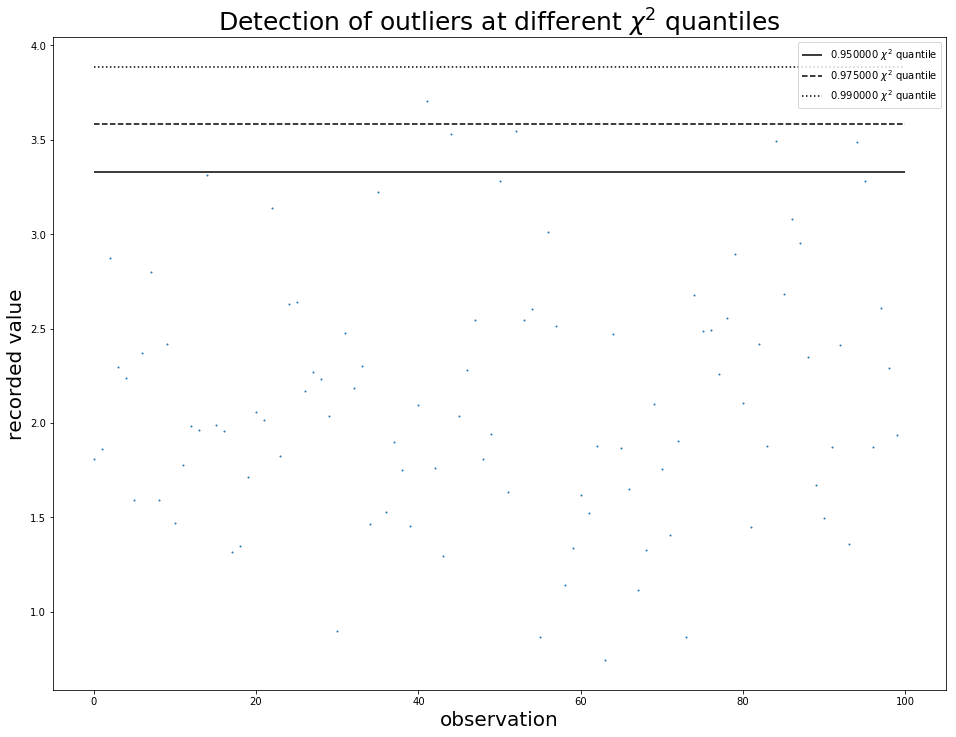

In [15]:
plot_outliers(maha_dis,0.95,0.975,0.99) #here recorded value is mahalanobis distance

Then we try to split the whole the dataset into 1000 subsets

In [26]:
X_train_scaled=feature_eng.fit_transform(X_train)
X_train_new,y_train_new,maha_dis=outliers_clean_direct(p_free=5,labels=y_train.copy()).fit_transform(X_train_scaled)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


MD Start
MD end
mahalanbios distance:  [ 3.3379388   3.37713725  3.03612973 ...,  1.8644143   1.26067642
  2.14461159]
cutoff value:  3.58224817594
Drop Start
Drop End
drop count: 23139


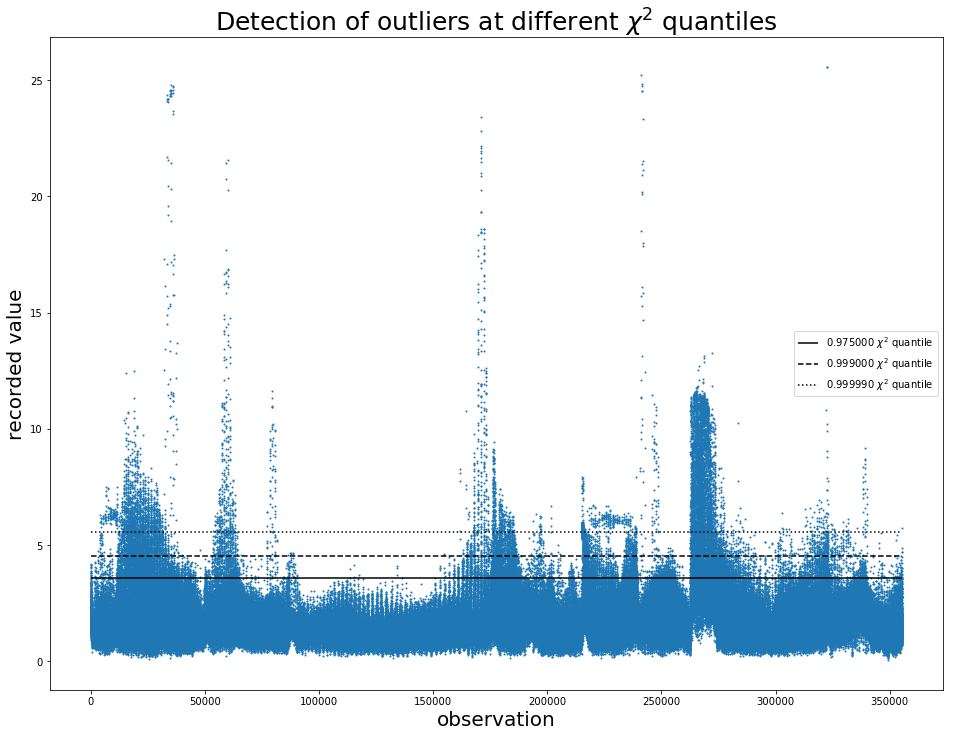

In [27]:
plot_outliers(maha_dis,0.975,0.999,0.99999)

in the first approach , there are 23139 outliers has been droped, then we implement robust algorithm and see

In [18]:
#resampling algorithm
p_distr=0.975
n_subsamples=np.ceil(log((1-p_distr),1-(0.5)**6)).astype(int)
n_subsamples

235

because the number of the subsample set $m$ satisfy $$1-(1-(1-0.5)^{p+1})^m\geq p_{distribution}$$ but this is a large number of groups and it will take a long time to calculate. Due to the paper we know the statistic order of the subset distance $m^2_{k+1}$ satisfly $$m^2_{k+1}\leq(\frac{V_k}{det(C_{k+1})})^{1/p}=M$$ so if $m^2_{k+1}$ exceed, then stop

In [29]:

class outliers_clean_resampling(BaseEstimator,TransformerMixin):
    def __init__(self,p_free,labels,md_dis=pd.Series([]),p_value_1=0.,p_value_2=0.,h_value=0):
        self.md_dis=md_dis
        self.p_value_1=p_value_1
        self.p_value_2=p_value_2
        self.p_free=p_free
        self.h_value=h_value
        self.labels=labels
    def fit(self,X,y=None):
        self.h_value=np.int((X.shape[0]+self.p_free+1)/2)
        mean_value=np.array([X.mean()])
        cov_value=np.mat(X.cov().as_matrix()).I
        print("MD Start")
        self.md_dis=distance.cdist(X,mean_value,metric='mahalanobis',VI=cov_value).ravel()
        print("MD end")
        chi2.fit(self.md_dis,self.p_free)
        self.p_value_1=np.sqrt(chi2.ppf(0.9999999999,self.p_free))
        self.p_value_2=np.sqrt(chi2.ppf(0.5,self.p_free))
        return self
    def transform(self,X,y=None):
        np.random.seed(30)
        mean_set,cov_set,m_dis_order,V_j=[],[],[],[]
        print("Resampling begin")
        start1=time.time()
        for subset in range(n_subsamples):
            if subset%50==0:
                print("replications number:%d time:%5.1f minute"%(subset,(time.time()-start1)/60))
            sample_ID=[]
            for index in range(self.p_free+1):
                sample_ID.append(np.random.choice(range(len(X)),replace=False))
            X_tr=np.array(X.iloc[sample_ID])
            sub_mean=np.array([(1/(self.p_free+1))*np.sum(X_tr,axis=0)])
            mean_set.append(sub_mean)
            sub_cov=np.mat((1/(self.p_free))*np.dot((X_tr-sub_mean).T,(X_tr-sub_mean))).I
            cov_set.append(sub_cov)
            m_dis=pd.Series((distance.cdist(X,sub_mean,metric='mahalanobis',VI=sub_cov)**2).ravel())\
            .sort_values(ascending=True).iloc[self.h_value] #ascending=True : from small to big
            #if subset != 0 :
                #if m_dis>=(V_j[subset-1]/sub_cov.I.det())**(1/self.p_free):
                    #break
                #else:
                    #pass
            m_dis_order.append(m_dis)
            V_j.append(m_dis*np.linalg.det(sub_cov))
        print("Resampling end")
        #print(m_dis_order[])
        J_index=pd.Series(V_j).sort_values(ascending=True).index.tolist()[0]
        m_dis_value=m_dis_order[J_index]
        robust_mean=mean_set[J_index]
        robust_cov=((1+15/(X.shape[0]-self.p_free))**2)*(1/self.p_value_2)*m_dis_value*cov_set[J_index]
        print("RD Start")
        robust_dis=distance.cdist(X,robust_mean,metric='mahalanobis',VI=robust_cov).ravel()
        print("RD end")
        print("Robust distance: ",robust_dis)
        print("Cutoff value: ",self.p_value_1)
        count,count1,count2=0,0,0
        count1=X.shape[0]
        print("Drop Start")
        robust_dis=pd.DataFrame(robust_dis,columns=['robust_dis'])
        X=pd.concat([X,robust_dis],axis=1)
        self.labels=pd.concat([self.labels,robust_dis],axis=1)
        X=X[X['robust_dis']<=self.p_value_1].copy()
        self.labels=self.labels[self.labels['robust_dis']<=self.p_value_1].copy()
        X=pd.DataFrame.reset_index(X).drop('index',axis=1)
        self.labels=pd.DataFrame.reset_index(self.labels).drop('index',axis=1)
        count2=X.shape[0]
        count=count1-count2
        print("Drop End")
        print("drop count:",count)
        return X,self.labels,robust_dis

In [20]:
#use test temp set for testing
sample,labelset,robust_dis=outliers_clean_resampling(p_free=5,labels=temp2).fit_transform(temp1)

MD Start
MD end
Resampling begin
replications number:0 time:  0.0 minute
replications number:50 time:  0.0 minute
replications number:100 time:  0.0 minute
replications number:150 time:  0.0 minute
replications number:200 time:  0.0 minute
Resampling end
RD Start
RD end
Robust distance:  [  1.12497266e+16   4.34368836e+16   2.88415780e+16   1.63201632e+16
   2.73450005e+16   8.81269053e+15   4.25962678e+16   2.26923447e+15
   9.73649053e+15   3.76334970e+16   3.91100784e+16   5.09510621e+16
   1.27138370e+16   1.40065272e+16   1.57852446e+16   1.65957052e+16
   4.69438286e+16   3.13931026e+16   2.07133329e+08   4.45270569e+16
   2.48906171e+16   1.90248060e+16   3.04781585e+16   4.53529966e+16
              nan   7.95400081e+16   1.65545099e+16   5.65408743e+16
   2.35699457e+16   7.17801193e+16   1.99401560e+16   5.73465861e+16
   5.74861851e+16   4.52459495e+16   1.96749001e+15   4.75882527e+15
   5.40586655e+16   3.12675525e+08   3.32443356e+16   1.56581713e+16
   2.08345842e+16   1

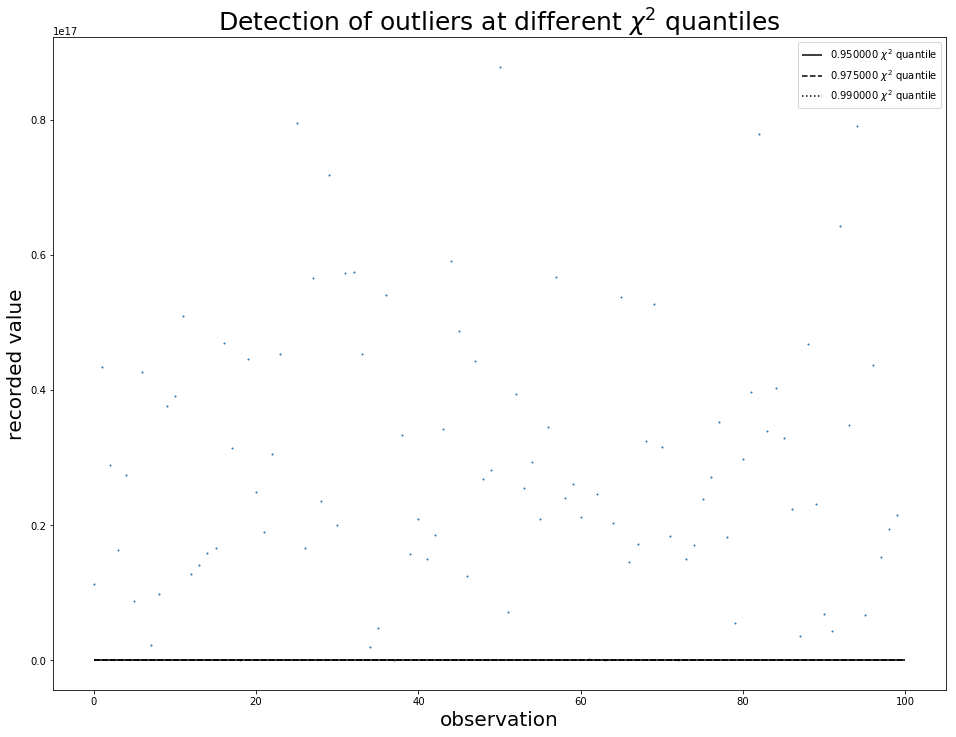

In [21]:
plot_outliers(robust_dis,0.95,0.975,0.99)

In [30]:
n_subsamples=253
X_train_scaled=feature_eng.fit_transform(X_train)
X_train_new,y_train_new,robust_dis=outliers_clean_resampling(p_free=5,labels=y_train).fit_transform(X_train_scaled)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


MD Start
MD end
Resampling begin
replications number:0 time:  0.0 minute
replications number:50 time:  0.6 minute
replications number:100 time:  1.2 minute
replications number:150 time:  1.8 minute
replications number:200 time:  2.3 minute
replications number:250 time:  2.9 minute
Resampling end
RD Start
RD end
Robust distance:  [ 6.90672993  7.42642383  5.88375227 ...,  4.07629182  3.38806106
  5.5977355 ]
Cutoff value:  7.45401893905
Drop Start
Drop End
drop count: 31944


In [292]:
n_subsamples=3000
X_train_scaled=feature_eng.fit_transform(X_train)
X_train_new,y_train_new,robust_dis=outliers_clean_resampling(p_free=5,labels=y_train).fit_transform(X_train_scaled)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


MD Start
MD end
Resampling begin
replications number:0 time:  0.0 minute
replications number:50 time:  0.7 minute
replications number:100 time:  1.3 minute
replications number:150 time:  2.0 minute
replications number:200 time:  2.6 minute
replications number:250 time:  3.3 minute
replications number:300 time:  4.0 minute
replications number:350 time:  4.6 minute
replications number:400 time:  5.2 minute
replications number:450 time:  5.9 minute
replications number:500 time:  6.5 minute
replications number:550 time:  7.1 minute
replications number:600 time:  7.8 minute
replications number:650 time:  8.4 minute
replications number:700 time:  9.0 minute
replications number:750 time:  9.7 minute
replications number:800 time: 10.3 minute
replications number:850 time: 10.9 minute
replications number:900 time: 11.5 minute
replications number:950 time: 12.2 minute
replications number:1000 time: 12.8 minute
replications number:1050 time: 13.5 minute
replications number:1100 time: 14.1 minute
r

In [294]:
#CAUTION!! don't overwirte this again
robust_dis=pd.Series(robust_dis)
robust_dis.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\mahalanobis_distance.csv",index=False)

In [110]:
robust_dis=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\mahalanobis_distance.csv")
robust_dis=np.array(maha_dis)

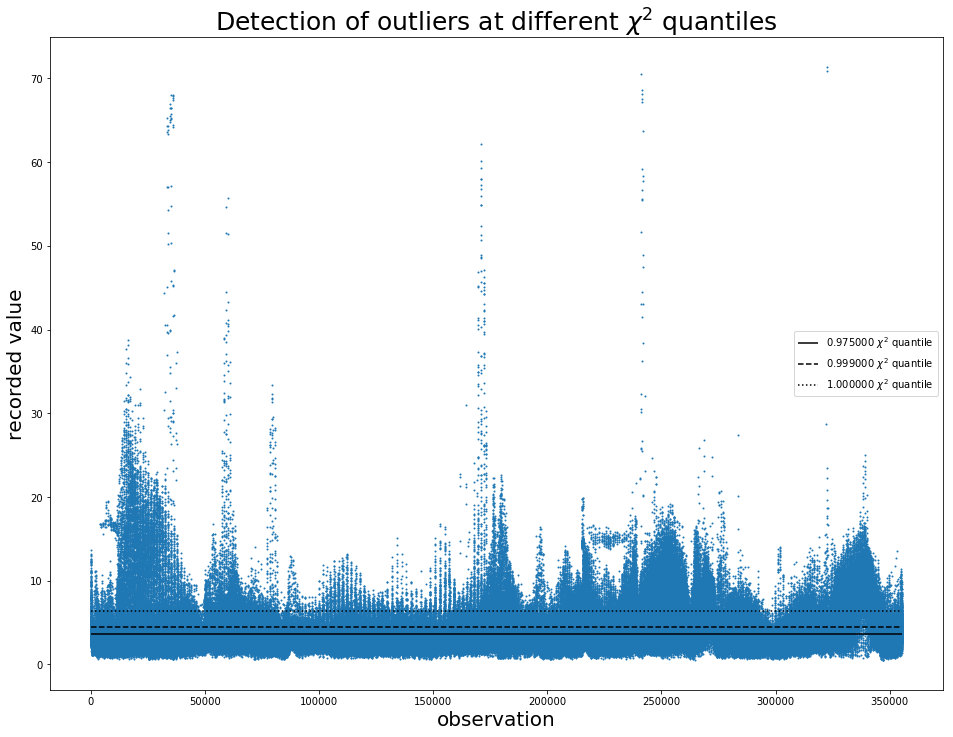

In [293]:
plot_outliers(robust_dis,0.975,0.999,0.9999999) #with n_subsamples=3000

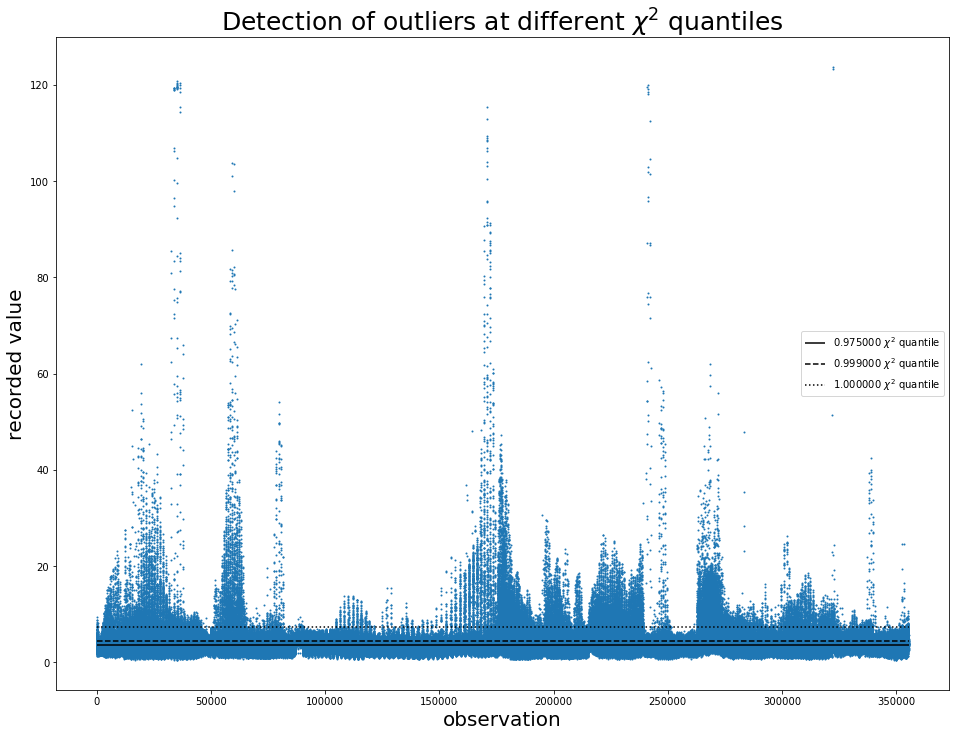

In [28]:
plot_outliers(robust_dis,0.975,0.999,0.9999999999) #with n_subsamples=253

**Tuning conclusion** :from the plot 1 and plot 2 we can figure out n_subsample or replications better remain low value

In [31]:
X_train_new.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_resampling_X.csv",index=False)
y_train_new.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_resampling_y.csv",index=False)

In [32]:
#the projection algorithm

## 3.3 Boundray selection

In [3]:
X_train=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_resampling_X.csv")
y_train=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_resampling_y.csv")

In [4]:
X_train=X_train.drop(['robust_dis'],axis=1)
y_train=y_train.drop(['robust_dis'],axis=1)
y_train=y_train.rename(columns={'0':'label'})

first to apply kmeans algorithm to divide dataset into clusters

In [5]:
#create a test dataset testing our kmeans
temp_X=pd.DataFrame(np.random.randn(100,5)*10)
temp_y=pd.DataFrame(np.append(np.ones((80,1)),np.ones((20,1))*2),columns=['label'])
#temp_train=pd.concat([temp_X,temp_y],axis=1)

In [6]:
kmeans=KMeans(n_clusters=np.int((temp_X.shape[0])/5),random_state=42)
kmeans.fit(temp_X)
kmeans.predict(temp_X)
y=pd.Series(kmeans.fit_predict(temp_X))
temp_train=pd.concat([temp_X,temp_y],axis=1)
temp1=temp_train[y==0]
temp=temp_train[y==0]['label']
if 1 and 2 in list(temp):
    print('yes')
else:
    temp_train=temp_train.drop(temp_train[y==0].index,axis=0)

NameError: name 'KMeans' is not defined

In [17]:
class boundary_detection(BaseEstimator,TransformerMixin):
    def __init__(self,labels,kmeans):
        self.labels=labels
        self.kmeans=kmeans
    def fit(self,X,y=None):
        start=time.time()
        print("fit start")
        self.kmeans.fit(X)
        print("fit end")
        print("fit time:%5.1fminute"%((time.time()-start)/60))
        return self
    def transform(self,X,y=None):
        dataset=pd.concat([X,self.labels],axis=1)
        count1=dataset.shape[0]
        y=pd.Series(self.kmeans.predict(X))
        print("drop start")
        for cluster in range(np.int((X.shape[0])/30)):
            if cluster%500==0:
                print("cluster number:",cluster)
            if 1 and 2 in list(dataset[y==cluster]['label']):
                pass
            else:
                dataset=dataset.drop(dataset[y==cluster].index,axis=0)
        dataset.append(pd.DataFrame(self.kmeans.cluster_centers_))
        print("drop end")
        count2=dataset.shape[0]
        print("Drop count:",count1-count2)        
        return dataset

In [18]:
train_set=boundary_detection(labels=temp_y,kmeans=KMeans(n_clusters=np.int((temp_X.shape[0])/5),random_state=42)).fit_transform(temp_X)

fit start
fit end
fit time:  0.0minute
drop start
cluster number: 0
cluster number: 10
drop end
Drop count: 15


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [20]:
train_set=boundary_detection(labels=temp_y,kmeans=MiniBatchKMeans(n_clusters=np.int((temp_X.shape[0])/5),\
                                                                  init_size=3*np.int((temp_X.shape[0])/5),verbose=-1,\
                                                                  random_state=42)).fit_transform(temp_X)

fit start
fit end
fit time:  0.0minute
drop start
cluster number: 0
cluster number: 10
drop end
Drop count: 28


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [8]:
train_set=boundary_detection(labels=y_train,kmeans=MiniBatchKMeans(n_clusters=np.int((X_train.shape[0])/30),n_init=1,max_iter=100,\
                                                                  init_size=3*np.int((X_train.shape[0])/30),verbose=-1,\
                                                                  random_state=42)).fit_transform(X_train)

fit start
Init 1/1 with method: k-means++
Inertia for init 1/1: 312.127038
Minibatch iteration 1/323600: mean batch inertia: 0.022546, ewa inertia: 0.022546 
Minibatch iteration 2/323600: mean batch inertia: 0.025333, ewa inertia: 0.022548 
Minibatch iteration 3/323600: mean batch inertia: 0.024398, ewa inertia: 0.022549 
Minibatch iteration 4/323600: mean batch inertia: 0.033320, ewa inertia: 0.022555 
Minibatch iteration 5/323600: mean batch inertia: 0.018913, ewa inertia: 0.022553 
Minibatch iteration 6/323600: mean batch inertia: 0.017381, ewa inertia: 0.022550 
Minibatch iteration 7/323600: mean batch inertia: 0.016957, ewa inertia: 0.022546 
Minibatch iteration 8/323600: mean batch inertia: 0.014410, ewa inertia: 0.022541 
Minibatch iteration 9/323600: mean batch inertia: 0.012869, ewa inertia: 0.022535 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 10/323600: mean batch inertia: 0.023291, ewa inertia: 0.022536 
Minibatch iteration 11/323600: mean batch in

Minibatch iteration 95/323600: mean batch inertia: 0.014435, ewa inertia: 0.022330 
Minibatch iteration 96/323600: mean batch inertia: 0.014747, ewa inertia: 0.022325 
Minibatch iteration 97/323600: mean batch inertia: 0.018221, ewa inertia: 0.022323 
Minibatch iteration 98/323600: mean batch inertia: 0.014879, ewa inertia: 0.022318 
Minibatch iteration 99/323600: mean batch inertia: 0.017275, ewa inertia: 0.022315 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 100/323600: mean batch inertia: 0.016735, ewa inertia: 0.022312 
Minibatch iteration 101/323600: mean batch inertia: 0.019104, ewa inertia: 0.022310 
Minibatch iteration 102/323600: mean batch inertia: 0.019610, ewa inertia: 0.022308 
Minibatch iteration 103/323600: mean batch inertia: 0.017394, ewa inertia: 0.022305 
Minibatch iteration 104/323600: mean batch inertia: 0.018826, ewa inertia: 0.022303 
Minibatch iteration 105/323600: mean batch inertia: 0.013539, ewa inertia: 0.022297 
Minibatch iteration 

Minibatch iteration 187/323600: mean batch inertia: 0.016218, ewa inertia: 0.022077 
Minibatch iteration 188/323600: mean batch inertia: 0.016692, ewa inertia: 0.022074 
Minibatch iteration 189/323600: mean batch inertia: 0.015616, ewa inertia: 0.022070 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 190/323600: mean batch inertia: 0.021197, ewa inertia: 0.022069 
Minibatch iteration 191/323600: mean batch inertia: 0.016957, ewa inertia: 0.022066 
Minibatch iteration 192/323600: mean batch inertia: 0.015143, ewa inertia: 0.022062 
Minibatch iteration 193/323600: mean batch inertia: 0.016970, ewa inertia: 0.022058 
Minibatch iteration 194/323600: mean batch inertia: 0.022009, ewa inertia: 0.022058 
Minibatch iteration 195/323600: mean batch inertia: 0.016976, ewa inertia: 0.022055 
Minibatch iteration 196/323600: mean batch inertia: 0.017825, ewa inertia: 0.022053 
Minibatch iteration 197/323600: mean batch inertia: 0.017422, ewa inertia: 0.022050 
Minibatch itera

Minibatch iteration 280/323600: mean batch inertia: 0.015490, ewa inertia: 0.021853 
Minibatch iteration 281/323600: mean batch inertia: 0.018213, ewa inertia: 0.021851 
Minibatch iteration 282/323600: mean batch inertia: 0.017956, ewa inertia: 0.021849 
Minibatch iteration 283/323600: mean batch inertia: 0.015180, ewa inertia: 0.021845 
Minibatch iteration 284/323600: mean batch inertia: 0.013397, ewa inertia: 0.021839 
Minibatch iteration 285/323600: mean batch inertia: 0.018142, ewa inertia: 0.021837 
Minibatch iteration 286/323600: mean batch inertia: 0.015621, ewa inertia: 0.021833 
Minibatch iteration 287/323600: mean batch inertia: 0.019715, ewa inertia: 0.021832 
Minibatch iteration 288/323600: mean batch inertia: 0.016688, ewa inertia: 0.021829 
Minibatch iteration 289/323600: mean batch inertia: 0.019353, ewa inertia: 0.021827 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 290/323600: mean batch inertia: 0.014818, ewa inertia: 0.021823 
Minibatch itera

Minibatch iteration 373/323600: mean batch inertia: 0.017148, ewa inertia: 0.021608 
Minibatch iteration 374/323600: mean batch inertia: 0.019282, ewa inertia: 0.021607 
Minibatch iteration 375/323600: mean batch inertia: 0.016436, ewa inertia: 0.021604 
Minibatch iteration 376/323600: mean batch inertia: 0.018893, ewa inertia: 0.021602 
Minibatch iteration 377/323600: mean batch inertia: 0.018209, ewa inertia: 0.021600 
Minibatch iteration 378/323600: mean batch inertia: 0.017025, ewa inertia: 0.021597 
Minibatch iteration 379/323600: mean batch inertia: 0.021635, ewa inertia: 0.021597 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 380/323600: mean batch inertia: 0.015736, ewa inertia: 0.021594 
Minibatch iteration 381/323600: mean batch inertia: 0.021746, ewa inertia: 0.021594 
Minibatch iteration 382/323600: mean batch inertia: 0.014971, ewa inertia: 0.021590 
Minibatch iteration 383/323600: mean batch inertia: 0.016557, ewa inertia: 0.021586 
Minibatch itera

Minibatch iteration 466/323600: mean batch inertia: 0.015853, ewa inertia: 0.021387 
Minibatch iteration 467/323600: mean batch inertia: 0.022842, ewa inertia: 0.021388 
Minibatch iteration 468/323600: mean batch inertia: 0.020338, ewa inertia: 0.021387 
Minibatch iteration 469/323600: mean batch inertia: 0.018775, ewa inertia: 0.021386 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 470/323600: mean batch inertia: 0.016644, ewa inertia: 0.021383 
Minibatch iteration 471/323600: mean batch inertia: 0.014037, ewa inertia: 0.021378 
Minibatch iteration 472/323600: mean batch inertia: 0.013644, ewa inertia: 0.021373 
Minibatch iteration 473/323600: mean batch inertia: 0.019124, ewa inertia: 0.021372 
Minibatch iteration 474/323600: mean batch inertia: 0.015167, ewa inertia: 0.021368 
Minibatch iteration 475/323600: mean batch inertia: 0.018928, ewa inertia: 0.021367 
Minibatch iteration 476/323600: mean batch inertia: 0.013900, ewa inertia: 0.021362 
Minibatch itera

Minibatch iteration 559/323600: mean batch inertia: 0.015630, ewa inertia: 0.021158 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 560/323600: mean batch inertia: 0.019053, ewa inertia: 0.021157 
Minibatch iteration 561/323600: mean batch inertia: 0.022689, ewa inertia: 0.021158 
Minibatch iteration 562/323600: mean batch inertia: 0.015134, ewa inertia: 0.021154 
Minibatch iteration 563/323600: mean batch inertia: 0.016786, ewa inertia: 0.021152 
Minibatch iteration 564/323600: mean batch inertia: 0.016018, ewa inertia: 0.021149 
Minibatch iteration 565/323600: mean batch inertia: 0.015093, ewa inertia: 0.021145 
Minibatch iteration 566/323600: mean batch inertia: 0.021621, ewa inertia: 0.021145 
Minibatch iteration 567/323600: mean batch inertia: 0.016131, ewa inertia: 0.021142 
Minibatch iteration 568/323600: mean batch inertia: 0.017703, ewa inertia: 0.021140 
Minibatch iteration 569/323600: mean batch inertia: 0.017969, ewa inertia: 0.021138 
[MiniBatchKMean

Minibatch iteration 652/323600: mean batch inertia: 0.015316, ewa inertia: 0.020955 
Minibatch iteration 653/323600: mean batch inertia: 0.013553, ewa inertia: 0.020950 
Minibatch iteration 654/323600: mean batch inertia: 0.015774, ewa inertia: 0.020947 
Minibatch iteration 655/323600: mean batch inertia: 0.019378, ewa inertia: 0.020946 
Minibatch iteration 656/323600: mean batch inertia: 0.017533, ewa inertia: 0.020944 
Minibatch iteration 657/323600: mean batch inertia: 0.014376, ewa inertia: 0.020940 
Minibatch iteration 658/323600: mean batch inertia: 0.015060, ewa inertia: 0.020936 
Minibatch iteration 659/323600: mean batch inertia: 0.017803, ewa inertia: 0.020934 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 660/323600: mean batch inertia: 0.014474, ewa inertia: 0.020930 
Minibatch iteration 661/323600: mean batch inertia: 0.017713, ewa inertia: 0.020928 
Minibatch iteration 662/323600: mean batch inertia: 0.017269, ewa inertia: 0.020926 
Minibatch itera

Minibatch iteration 747/323600: mean batch inertia: 0.015207, ewa inertia: 0.020691 
Minibatch iteration 748/323600: mean batch inertia: 0.014898, ewa inertia: 0.020687 
Minibatch iteration 749/323600: mean batch inertia: 0.015541, ewa inertia: 0.020684 
Minibatch iteration 750/323600: mean batch inertia: 0.012028, ewa inertia: 0.020679 
Minibatch iteration 751/323600: mean batch inertia: 0.015203, ewa inertia: 0.020675 
Minibatch iteration 752/323600: mean batch inertia: 0.018242, ewa inertia: 0.020674 
Minibatch iteration 753/323600: mean batch inertia: 0.013300, ewa inertia: 0.020669 
Minibatch iteration 754/323600: mean batch inertia: 0.015854, ewa inertia: 0.020666 
Minibatch iteration 755/323600: mean batch inertia: 0.023468, ewa inertia: 0.020668 
Minibatch iteration 756/323600: mean batch inertia: 0.013151, ewa inertia: 0.020663 
Minibatch iteration 757/323600: mean batch inertia: 0.020014, ewa inertia: 0.020663 
Minibatch iteration 758/323600: mean batch inertia: 0.017857, ewa

Minibatch iteration 846/323600: mean batch inertia: 0.016227, ewa inertia: 0.020467 
Minibatch iteration 847/323600: mean batch inertia: 0.014191, ewa inertia: 0.020463 
Minibatch iteration 848/323600: mean batch inertia: 0.019680, ewa inertia: 0.020463 
Minibatch iteration 849/323600: mean batch inertia: 0.020458, ewa inertia: 0.020463 
Minibatch iteration 850/323600: mean batch inertia: 0.013635, ewa inertia: 0.020459 
Minibatch iteration 851/323600: mean batch inertia: 0.012932, ewa inertia: 0.020454 
Minibatch iteration 852/323600: mean batch inertia: 0.013439, ewa inertia: 0.020450 
Minibatch iteration 853/323600: mean batch inertia: 0.018656, ewa inertia: 0.020448 
Minibatch iteration 854/323600: mean batch inertia: 0.017663, ewa inertia: 0.020447 
Minibatch iteration 855/323600: mean batch inertia: 0.015790, ewa inertia: 0.020444 
Minibatch iteration 856/323600: mean batch inertia: 0.018757, ewa inertia: 0.020443 
Minibatch iteration 857/323600: mean batch inertia: 0.018279, ewa

Minibatch iteration 944/323600: mean batch inertia: 0.017338, ewa inertia: 0.020243 
Minibatch iteration 945/323600: mean batch inertia: 0.015747, ewa inertia: 0.020240 
Minibatch iteration 946/323600: mean batch inertia: 0.014223, ewa inertia: 0.020236 
Minibatch iteration 947/323600: mean batch inertia: 0.012520, ewa inertia: 0.020232 
Minibatch iteration 948/323600: mean batch inertia: 0.020641, ewa inertia: 0.020232 
Minibatch iteration 949/323600: mean batch inertia: 0.014043, ewa inertia: 0.020228 
Minibatch iteration 950/323600: mean batch inertia: 0.014884, ewa inertia: 0.020225 
Minibatch iteration 951/323600: mean batch inertia: 0.014471, ewa inertia: 0.020221 
Minibatch iteration 952/323600: mean batch inertia: 0.012860, ewa inertia: 0.020217 
Minibatch iteration 953/323600: mean batch inertia: 0.016385, ewa inertia: 0.020214 
Minibatch iteration 954/323600: mean batch inertia: 0.016185, ewa inertia: 0.020212 
Minibatch iteration 955/323600: mean batch inertia: 0.020271, ewa

Minibatch iteration 1040/323600: mean batch inertia: 0.015801, ewa inertia: 0.020009 
Minibatch iteration 1041/323600: mean batch inertia: 0.020292, ewa inertia: 0.020009 
Minibatch iteration 1042/323600: mean batch inertia: 0.012457, ewa inertia: 0.020004 
Minibatch iteration 1043/323600: mean batch inertia: 0.020881, ewa inertia: 0.020005 
Minibatch iteration 1044/323600: mean batch inertia: 0.020241, ewa inertia: 0.020005 
Minibatch iteration 1045/323600: mean batch inertia: 0.016141, ewa inertia: 0.020003 
Minibatch iteration 1046/323600: mean batch inertia: 0.013197, ewa inertia: 0.019998 
Minibatch iteration 1047/323600: mean batch inertia: 0.014175, ewa inertia: 0.019995 
Minibatch iteration 1048/323600: mean batch inertia: 0.018569, ewa inertia: 0.019994 
Minibatch iteration 1049/323600: mean batch inertia: 0.013919, ewa inertia: 0.019990 
Minibatch iteration 1050/323600: mean batch inertia: 0.014748, ewa inertia: 0.019987 
Minibatch iteration 1051/323600: mean batch inertia: 0

Minibatch iteration 1137/323600: mean batch inertia: 0.013871, ewa inertia: 0.019809 
Minibatch iteration 1138/323600: mean batch inertia: 0.016281, ewa inertia: 0.019807 
Minibatch iteration 1139/323600: mean batch inertia: 0.013761, ewa inertia: 0.019803 
Minibatch iteration 1140/323600: mean batch inertia: 0.016471, ewa inertia: 0.019801 
Minibatch iteration 1141/323600: mean batch inertia: 0.020381, ewa inertia: 0.019801 
Minibatch iteration 1142/323600: mean batch inertia: 0.018396, ewa inertia: 0.019800 
Minibatch iteration 1143/323600: mean batch inertia: 0.012722, ewa inertia: 0.019796 
Minibatch iteration 1144/323600: mean batch inertia: 0.015389, ewa inertia: 0.019793 
Minibatch iteration 1145/323600: mean batch inertia: 0.019728, ewa inertia: 0.019793 
Minibatch iteration 1146/323600: mean batch inertia: 0.016190, ewa inertia: 0.019791 
Minibatch iteration 1147/323600: mean batch inertia: 0.014056, ewa inertia: 0.019787 
Minibatch iteration 1148/323600: mean batch inertia: 0

Minibatch iteration 1233/323600: mean batch inertia: 0.015975, ewa inertia: 0.019609 
Minibatch iteration 1234/323600: mean batch inertia: 0.020384, ewa inertia: 0.019610 
Minibatch iteration 1235/323600: mean batch inertia: 0.014056, ewa inertia: 0.019607 
Minibatch iteration 1236/323600: mean batch inertia: 0.014720, ewa inertia: 0.019603 
Minibatch iteration 1237/323600: mean batch inertia: 0.014826, ewa inertia: 0.019601 
Minibatch iteration 1238/323600: mean batch inertia: 0.013066, ewa inertia: 0.019596 
Minibatch iteration 1239/323600: mean batch inertia: 0.016130, ewa inertia: 0.019594 
Minibatch iteration 1240/323600: mean batch inertia: 0.017244, ewa inertia: 0.019593 
Minibatch iteration 1241/323600: mean batch inertia: 0.015693, ewa inertia: 0.019590 
Minibatch iteration 1242/323600: mean batch inertia: 0.013552, ewa inertia: 0.019587 
Minibatch iteration 1243/323600: mean batch inertia: 0.016081, ewa inertia: 0.019585 
Minibatch iteration 1244/323600: mean batch inertia: 0

Minibatch iteration 1329/323600: mean batch inertia: 0.019384, ewa inertia: 0.019422 
Minibatch iteration 1330/323600: mean batch inertia: 0.015400, ewa inertia: 0.019419 
Minibatch iteration 1331/323600: mean batch inertia: 0.014423, ewa inertia: 0.019416 
Minibatch iteration 1332/323600: mean batch inertia: 0.015018, ewa inertia: 0.019413 
Minibatch iteration 1333/323600: mean batch inertia: 0.019990, ewa inertia: 0.019414 
Minibatch iteration 1334/323600: mean batch inertia: 0.015248, ewa inertia: 0.019411 
Minibatch iteration 1335/323600: mean batch inertia: 0.016938, ewa inertia: 0.019410 
Minibatch iteration 1336/323600: mean batch inertia: 0.015425, ewa inertia: 0.019407 
Minibatch iteration 1337/323600: mean batch inertia: 0.013901, ewa inertia: 0.019404 
Minibatch iteration 1338/323600: mean batch inertia: 0.019210, ewa inertia: 0.019404 
Minibatch iteration 1339/323600: mean batch inertia: 0.016177, ewa inertia: 0.019402 
Minibatch iteration 1340/323600: mean batch inertia: 0

Minibatch iteration 1425/323600: mean batch inertia: 0.019702, ewa inertia: 0.019215 
Minibatch iteration 1426/323600: mean batch inertia: 0.021778, ewa inertia: 0.019217 
Minibatch iteration 1427/323600: mean batch inertia: 0.016771, ewa inertia: 0.019215 
Minibatch iteration 1428/323600: mean batch inertia: 0.012620, ewa inertia: 0.019211 
Minibatch iteration 1429/323600: mean batch inertia: 0.016717, ewa inertia: 0.019209 
Minibatch iteration 1430/323600: mean batch inertia: 0.017622, ewa inertia: 0.019208 
Minibatch iteration 1431/323600: mean batch inertia: 0.017065, ewa inertia: 0.019207 
Minibatch iteration 1432/323600: mean batch inertia: 0.015176, ewa inertia: 0.019205 
Minibatch iteration 1433/323600: mean batch inertia: 0.016348, ewa inertia: 0.019203 
Minibatch iteration 1434/323600: mean batch inertia: 0.015726, ewa inertia: 0.019201 
Minibatch iteration 1435/323600: mean batch inertia: 0.016523, ewa inertia: 0.019199 
Minibatch iteration 1436/323600: mean batch inertia: 0

Minibatch iteration 1521/323600: mean batch inertia: 0.016453, ewa inertia: 0.019027 
Minibatch iteration 1522/323600: mean batch inertia: 0.014745, ewa inertia: 0.019024 
Minibatch iteration 1523/323600: mean batch inertia: 0.015037, ewa inertia: 0.019022 
Minibatch iteration 1524/323600: mean batch inertia: 0.016448, ewa inertia: 0.019020 
Minibatch iteration 1525/323600: mean batch inertia: 0.012981, ewa inertia: 0.019016 
Minibatch iteration 1526/323600: mean batch inertia: 0.014836, ewa inertia: 0.019014 
Minibatch iteration 1527/323600: mean batch inertia: 0.016780, ewa inertia: 0.019012 
Minibatch iteration 1528/323600: mean batch inertia: 0.014932, ewa inertia: 0.019010 
Minibatch iteration 1529/323600: mean batch inertia: 0.017603, ewa inertia: 0.019009 
Minibatch iteration 1530/323600: mean batch inertia: 0.013329, ewa inertia: 0.019005 
Minibatch iteration 1531/323600: mean batch inertia: 0.016325, ewa inertia: 0.019004 
Minibatch iteration 1532/323600: mean batch inertia: 0

Minibatch iteration 1617/323600: mean batch inertia: 0.013075, ewa inertia: 0.018854 
Minibatch iteration 1618/323600: mean batch inertia: 0.015903, ewa inertia: 0.018852 
Minibatch iteration 1619/323600: mean batch inertia: 0.014220, ewa inertia: 0.018849 
Minibatch iteration 1620/323600: mean batch inertia: 0.012970, ewa inertia: 0.018845 
Minibatch iteration 1621/323600: mean batch inertia: 0.018012, ewa inertia: 0.018845 
Minibatch iteration 1622/323600: mean batch inertia: 0.014758, ewa inertia: 0.018842 
Minibatch iteration 1623/323600: mean batch inertia: 0.015231, ewa inertia: 0.018840 
Minibatch iteration 1624/323600: mean batch inertia: 0.017677, ewa inertia: 0.018839 
Minibatch iteration 1625/323600: mean batch inertia: 0.013775, ewa inertia: 0.018836 
Minibatch iteration 1626/323600: mean batch inertia: 0.020639, ewa inertia: 0.018837 
Minibatch iteration 1627/323600: mean batch inertia: 0.020608, ewa inertia: 0.018839 
Minibatch iteration 1628/323600: mean batch inertia: 0

Minibatch iteration 1713/323600: mean batch inertia: 0.019602, ewa inertia: 0.018699 
Minibatch iteration 1714/323600: mean batch inertia: 0.015293, ewa inertia: 0.018697 
Minibatch iteration 1715/323600: mean batch inertia: 0.017243, ewa inertia: 0.018696 
Minibatch iteration 1716/323600: mean batch inertia: 0.017794, ewa inertia: 0.018695 
Minibatch iteration 1717/323600: mean batch inertia: 0.017630, ewa inertia: 0.018694 
Minibatch iteration 1718/323600: mean batch inertia: 0.019221, ewa inertia: 0.018695 
Minibatch iteration 1719/323600: mean batch inertia: 0.016870, ewa inertia: 0.018694 
Minibatch iteration 1720/323600: mean batch inertia: 0.019075, ewa inertia: 0.018694 
Minibatch iteration 1721/323600: mean batch inertia: 0.018027, ewa inertia: 0.018693 
Minibatch iteration 1722/323600: mean batch inertia: 0.014519, ewa inertia: 0.018691 
Minibatch iteration 1723/323600: mean batch inertia: 0.017302, ewa inertia: 0.018690 
Minibatch iteration 1724/323600: mean batch inertia: 0

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


cluster number: 500
cluster number: 1000
cluster number: 1500
cluster number: 2000
cluster number: 2500
cluster number: 3000
cluster number: 3500
cluster number: 4000
cluster number: 4500
cluster number: 5000
cluster number: 5500
cluster number: 6000
cluster number: 6500
cluster number: 7000
cluster number: 7500
cluster number: 8000
cluster number: 8500
cluster number: 9000
cluster number: 9500
cluster number: 10000
cluster number: 10500
drop end
Drop count: 101382


In [18]:
train_set=boundary_detection(labels=y_train,kmeans=MiniBatchKMeans(n_clusters=np.int((X_train.shape[0])/10),n_init=3,max_iter=100,\
                                                                  init_size=3*np.int((X_train.shape[0])/10),verbose=-1,\
                                                                  random_state=42)).fit_transform(X_train)

fit start
Init 1/3 with method: k-means++
Inertia for init 1/3: 515.555794
Init 2/3 with method: k-means++
Inertia for init 2/3: 517.568871
Init 3/3 with method: k-means++
Inertia for init 3/3: 520.837646
Minibatch iteration 1/323600: mean batch inertia: 0.010051, ewa inertia: 0.010051 
Minibatch iteration 2/323600: mean batch inertia: 0.011338, ewa inertia: 0.010052 
Minibatch iteration 3/323600: mean batch inertia: 0.008977, ewa inertia: 0.010052 
Minibatch iteration 4/323600: mean batch inertia: 0.012109, ewa inertia: 0.010053 
Minibatch iteration 5/323600: mean batch inertia: 0.009666, ewa inertia: 0.010053 
Minibatch iteration 6/323600: mean batch inertia: 0.011481, ewa inertia: 0.010054 
Minibatch iteration 7/323600: mean batch inertia: 0.009466, ewa inertia: 0.010053 
Minibatch iteration 8/323600: mean batch inertia: 0.007315, ewa inertia: 0.010051 
Minibatch iteration 9/323600: mean batch inertia: 0.008762, ewa inertia: 0.010051 
[MiniBatchKMeans] Reassigning 50 cluster centers

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


cluster number: 500
cluster number: 1000
cluster number: 1500
cluster number: 2000
cluster number: 2500
cluster number: 3000
cluster number: 3500
cluster number: 4000
cluster number: 4500
cluster number: 5000
cluster number: 5500
cluster number: 6000
cluster number: 6500
cluster number: 7000
cluster number: 7500
cluster number: 8000
cluster number: 8500
cluster number: 9000
cluster number: 9500
cluster number: 10000
cluster number: 10500
drop end
Drop count: 55330


In [19]:
train_set.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_set.csv",index=False)

# 4. Build the model

In the model construction part ,**our plan ** is that:
- train servarl models
- calculate the f1-scores,accuracy,roc_curve
- choose the best model
- tuning the parameters of the model

In [3]:
train_set=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_set.csv")
X_val=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\val_feature.csv")
y_val=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\val_label.csv")
X_train=train_set.drop(["label"],axis=1)
y_train=train_set["label"]

In [11]:
#first apply nearest mean classifier
nn_clf=KNeighborsClassifier(n_neighbors=1,metric="mahalanobis",metric_params={'V':X_train.cov()},n_jobs=-1)
nn_clf.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='mahalanobis',
           metric_params={'V':           0         1         2         3         4
0  0.012394 -0.018409 -0.009229 -0.051703  0.033214
1 -0.018409  0.310909  0.062330  0.285187  0.029046
2 -0.009229  0.062330  0.146432  0.079157 -0.007718
3 -0.051703  0.285187  0.079157  0.852209 -0.038779
4  0.033214  0.029046 -0.007718 -0.038779  0.775245},
           n_jobs=-1, n_neighbors=1, p=2, weights='uniform')

In [12]:
np.random.seed(42)
index=np.random.choice(X_train.shape[0],size=np.int(X_train.shape[0]*0.001),replace=False)

we use the f1 score to analysis our model, $$P_{f1}=2*\frac{1}{\frac{1}{P_{recall}}+\frac{1}{P_{precision}}}$$

In [ ]:
X_train_select,y_train_select=X_train.loc[index],y_train.loc[index]
#f1 scores
y_pred=nn_clf.predict(X_train)
y_proba=nn_clf.predict_proba(X_train)
f1_score(y_train,y_pred)

In [30]:
y_train_select=np.array(y_train_select.tolist())

In [32]:
#calculate tp amd fp
y_score=y_proba[:,1]
fp_nn,tp_nn,thresholds_nn=roc_curve(y_train_select,y_score,pos_label=2)

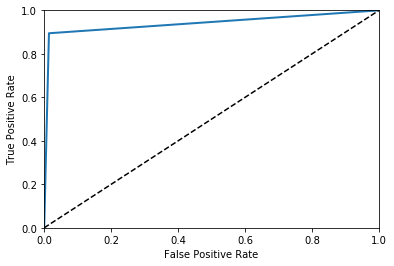

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fp_nn,tp_nn,label='Nearest Mean')
plt.show()

In [34]:
#then apply k nearest mean classifier
knn_clf=KNeighborsClassifier(n_neighbors=5,metric="mahalanobis",metric_params={'V':X_train.cov()},n_jobs=-1)
knn_clf.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='mahalanobis',
           metric_params={'V':           0         1         2         3         4
0  0.012394 -0.018409 -0.009229 -0.051703  0.033214
1 -0.018409  0.310909  0.062330  0.285187  0.029046
2 -0.009229  0.062330  0.146432  0.079157 -0.007718
3 -0.051703  0.285187  0.079157  0.852209 -0.038779
4  0.033214  0.029046 -0.007718 -0.038779  0.775245},
           n_jobs=-1, n_neighbors=5, p=2, weights='uniform')

In [35]:
X_train_select,y_train_select=X_train.loc[index],y_train.loc[index
X_train_select.shape

(268, 5)

In [37]:
#f1 scores
y_pred=knn_clf.predict(X_train_select)
y_proba=knn_clf.predict_proba(X_train_select)
f1_score(y_train_select,y_pred)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:131: RuntimeWarning: invalid value encountered in sqrt
  return [func(*args, **kwargs) for func, args, kwargs in self.items]


0.93577981651376152

In [44]:
#calculate tp amd fp
y_score=y_proba[:,1]
fp_knn,tp_knn,thresholds_knn=roc_curve(y_train_select,y_score,pos_label=2)

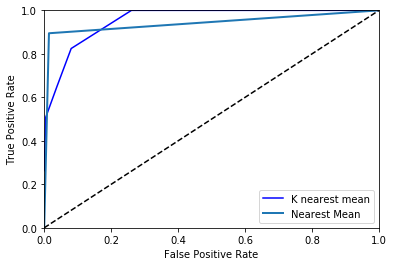

In [45]:
plt.plot(fp_knn,tp_knn,"b-",label="K nearest mean")
plot_roc_curve(fp_nn,tp_nn,label='Nearest Mean')
plt.legend()
plt.show()

In [8]:
#accuracy
accuracy_score(y_train_select,y_pred)

0.89552238805970152

from above we see the f1 scores of training set is 0.9279

In [37]:
X_val=feature_eng.transform(X_val)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [42]:
index_val=np.random.choice(X_val.shape[0],size=np.int(X_val.shape[0]*0.1),replace=False)
X_val_select,y_val_select=X_val.loc[index_val],y_val.loc[index_val]

In [43]:
y_pred=nn_clf.predict(X_val_select)
f1_score(y_val_select,y_pred)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:131: RuntimeWarning: invalid value encountered in sqrt
  return [func(*args, **kwargs) for func, args, kwargs in self.items]


0.9742102665350445

In [52]:
#use random forest to make a test
rdf_clf=RandomForestClassifier(random_state=42)
y_proba=cross_val_predict(rdf_clf,X_train,y_train,cv=3,method="predict_proba")

In [57]:
y_score=y_proba[:,1]
fp_rdf,tp_rdf,thresholds_rdf=roc_curve(y_train,y_score,pos_label=2)

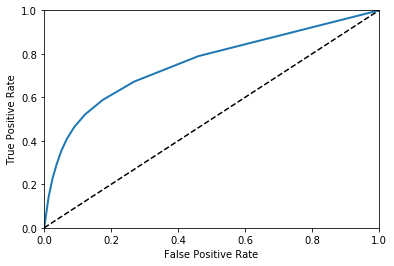

In [58]:
plot_roc_curve(fp_rdf,tp_rdf,label='randomforest')